In [2]:
import mediapipe as mp
import cv2
import numpy as np

class FeatureExtraction:
    def __init__(self, static_image_mode=False, max_num_faces=1, refine_landmarks=False, min_detection_con=0.5, min_tracking_con=0.5):
        # Initialize the parameters for face mesh detection
        self.static_image_mode = static_image_mode  # Whether to process images (True) or video stream (False)
        self.max_num_faces = max_num_faces  # Maximum number of faces to detect
        self.refine_landmarks = refine_landmarks  # Whether to refine iris landmarks for better precision
        self.min_detection_con = min_detection_con  # Minimum confidence for face detection
        self.min_tracking_con = min_tracking_con  # Minimum confidence for tracking

        # Initialize Mediapipe FaceMesh solution
        self.mpFaceMesh = mp.solutions.face_mesh
        self.faceMesh = self.mpFaceMesh.FaceMesh(self.static_image_mode,
                                                 self.max_num_faces,
                                                 self.refine_landmarks,
                                                 self.min_detection_con,
                                                 self.min_tracking_con)

        # Store the landmark indices for specific facial features
        # These are predefined Mediapipe indices for left and right eyes and mouth

        # self.LEFT_EYE_LANDMARKS = [63, 105, 66, 107, 55, 189,128, 119 , 117,111 ]  # Left eye landmarks
        self.LEFT_EYE_LANDMARKS = [63, 107, 128 ,117 ]  # Left eye landmarks

        self.RIGHT_EYE_LANDMARKS = [336, 293, 346, 357]  # Right eye landmarks
        
        self.MOUTH_LANDMARKS = [216 , 436, 430, 210]  # Mouth landmarks

    def extract_features(self, img):
         # Initialize a dictionary to store the landmarks for facial features
        landmarks = {}

        # Convert the input image to RGB as Mediapipe expects RGB images
        imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Process the image to find face landmarks using the FaceMesh model
        results = self.faceMesh.process(imgRGB)

        # Check if any faces were detected
        if results.multi_face_landmarks:
            # Iterate over detected faces (here, max_num_faces = 1, so usually one face)
            for faceLms in results.multi_face_landmarks:
                # Initialize lists in the landmarks dictionary to store each facial feature's coordinates
                landmarks["left_eye_landmarks"] = []
                landmarks["right_eye_landmarks"] = []
                landmarks["mouth_landmarks"] = []
                # landmarks["all_landmarks"] = []  # Store all face landmarks for complete face mesh
                
                # Loop through all face landmarks
                for i, lm in enumerate(faceLms.landmark):
                    h, w, ic = img.shape  # Get image height, width, and channel count
                    x, y = int(lm.x * w), int(lm.y * h)  # Convert normalized coordinates to pixel values
                    
                    # Store the coordinates of all landmarks
                    # landmarks["all_landmarks"].append((x, y))

                    # Store specific feature landmarks based on the predefined indices
                    if i in self.LEFT_EYE_LANDMARKS:
                        landmarks["left_eye_landmarks"].append((x, y))  # Left eye
                    if i in self.RIGHT_EYE_LANDMARKS:
                        landmarks["right_eye_landmarks"].append((x, y))  # Right eye
                    if i in self.MOUTH_LANDMARKS:
                        landmarks["mouth_landmarks"].append((x, y))  # Mouth

        # Return the processed image and the dictionary of feature landmarks
        return landmarks
    
    
    def get_feature_region(self, img, landmarks, padding=10):
        if not landmarks:
            return None
            
        # Get bounding box coordinates
        x_coords = [x for x, y in landmarks]
        y_coords = [y for x, y in landmarks]
        
        left = max(0, min(x_coords) - padding)
        right = min(img.shape[1], max(x_coords) + padding)
        top = max(0, min(y_coords) - padding)
        bottom = min(img.shape[0], max(y_coords) + padding)
        
        # Extract the region
        region = img[top:bottom, left:right]
        
        # Ensure the region is not empty
        if region.size == 0:
            return None
    
        region = self.enhance_image_quality(region)
        
        
        return region
    
    def enhance_image_quality(self, region):
    
    # 1. Apply Gaussian blur to reduce noise
        blurred = cv2.GaussianBlur(region, (3, 3), 0)
        
        # 2. Enhance details using unsharp masking
        gaussian = cv2.GaussianBlur(blurred, (0, 0), 2.0)
        unsharp_mask = cv2.addWeighted(blurred, 1.5, gaussian, -0.5, 0)
        
        # 3. Adaptive histogram equalization for better contrast
        lab = cv2.cvtColor(unsharp_mask, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        l = clahe.apply(l)
        enhanced = cv2.merge([l, a, b])
        enhanced = cv2.cvtColor(enhanced, cv2.COLOR_LAB2RGB)
        
        # 4. Maintain aspect ratio while resizing
        aspect_ratio = region.shape[1] / region.shape[0]
        if aspect_ratio > 1:
            new_width = 100
            new_height = int(new_width / aspect_ratio)
        else:
            new_height = 100
            new_width = int(new_height * aspect_ratio)
        
        # 5. High-quality resize with Lanczos interpolation
        final_region = cv2.resize(enhanced, (new_width, new_height), 
                                interpolation=cv2.INTER_LANCZOS4)
    
        return final_region
    
  

   


# Simple Cropping


I0000 00:00:1737284373.172106  178050 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1737284373.182181  180831 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737284373.188987  180831 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737284373.195980  180825 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


image_rgb.shape (360, 540, 3)


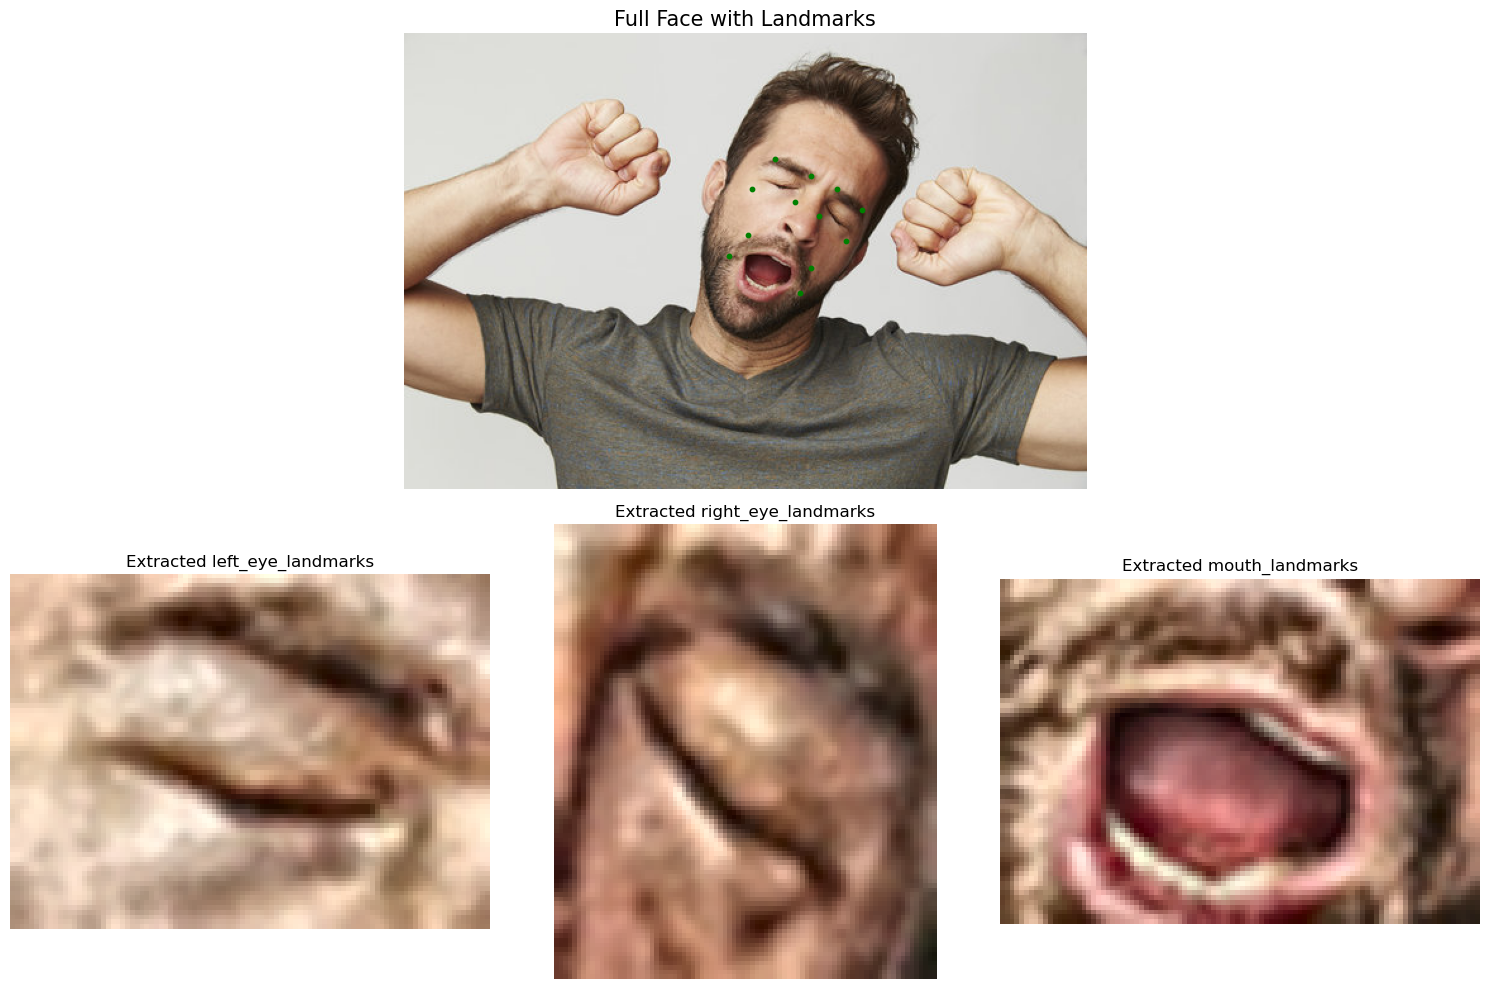

left_eye_landmarks region shape: (72, 100, 3)
right_eye_landmarks region shape: (100, 82, 3)
mouth_landmarks region shape: (70, 100, 3)


In [3]:
import matplotlib.pyplot as plt

# Initialize the detector
detector = FeatureExtraction(refine_landmarks=False)

# Read an image
image = cv2.imread("/Users/ahmedalkhulayfi/Downloads/360_F_136439169_Ih8iIKpTsG2SFsl02rXfyBKzrplMzh38.jpg")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print("image_rgb.shape", image_rgb.shape)

# Get landmarks
landmarks = detector.extract_features(image)

# Create figure with 2 rows: full face on top, extracted regions on bottom
fig = plt.figure(figsize=(15, 10))

# Plot full face with landmarks in first row
ax1 = plt.subplot(2, 1, 1)
ax1.imshow(image_rgb)
ax1.set_title('Full Face with Landmarks', fontsize=15)
ax1.axis('off')

# Plot landmarks on full face
for feature in ['left_eye_landmarks', 'right_eye_landmarks', 'mouth_landmarks']:
    for landmark in landmarks[feature]:
        ax1.scatter(landmark[0], landmark[1], c='g', s=10)

# Create three subplots in second row for extracted regions
ax2 = plt.subplot(2, 3, 4)
ax3 = plt.subplot(2, 3, 5)
ax4 = plt.subplot(2, 3, 6)

# Get and display extracted regions
features = ['left_eye_landmarks', 'right_eye_landmarks', 'mouth_landmarks']
axes = [ax2, ax3, ax4]

for feature, ax in zip(features, axes):
    # Get region
    region = detector.get_feature_region(image_rgb, landmarks[feature], padding=2)
    
    if region is not None:
        ax.imshow(region)
        ax.set_title(f'Extracted {feature}', fontsize=12)
        ax.axis('off')

plt.tight_layout()
plt.show()

# Print region shapes for verification
for feature in features:
    region = detector.get_feature_region(image_rgb, landmarks[feature], padding=0)
    if region is not None:
        print(f"{feature} region shape: {region.shape}")

In [ ]:
import matplotlib.pyplot as plt

# Initialize the FaceMeshDetector with refined iris landmarks for better precision
detector = FeatureExtraction(refine_landmarks=True)

# Define the facial features (eyes, nose, mouth, iris, and all landmarks) we are interested in
face_parts =  ["left_eye_landmarks", "right_eye_landmarks", "mouth_landmarks", ]


# Read an image from a specified file path
image = cv2.imread("/Users/ahmedalkhulayfi/Downloads/istockphoto-507995592-612x612.jpg")

# Convert the image to RGB for matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Use the FaceMeshDetector to find facial landmarks in the current frame
landmarks = detector.extract_features(image)
print(landmarks["left_eye_landmarks"])

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Iterate over each face part and corresponding subplot
for i, face_part in enumerate(face_parts):
    ax = axes[i]
    ax.imshow(image_rgb)
    ax.axis('off')
    ax.set_title(face_part, fontsize=15, color='green')

    # Try to draw the landmarks for the specified face part
    try:
        for landmark in landmarks[face_part]:
            ax.scatter(landmark[0], landmark[1], c='g', s=10)  # Green color, size 10
    except KeyError:
        # If the landmark for the specified part is not found, skip drawing
        pass

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Convex Hulls

In [48]:
def get_convex_hull_region(img, landmarks, padding=10):
        if not landmarks:
            return None

        # Convert landmarks to a NumPy array
        points = np.array(landmarks)

        # Calculate the convex hull
        hull = cv2.convexHull(points)

        # Create a mask for the region
        mask = np.zeros(img.shape[:2], dtype=np.uint8)
        cv2.fillConvexPoly(mask, hull, 255)

        # Extract the region using the mask
        region = cv2.bitwise_and(img, img, mask=mask)

        # Get the bounding box of the convex hull
        x, y, w, h = cv2.boundingRect(hull)
        region = region[y:y+h, x:x+w]

        # Ensure the region is not empty
        if region.size == 0:
            return None

        return region

(35, 48, 3)
(42, 35, 3)
(47, 66, 3)


I0000 00:00:1737193572.694245   33360 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1
W0000 00:00:1737193572.695424  118974 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737193572.701831  118972 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


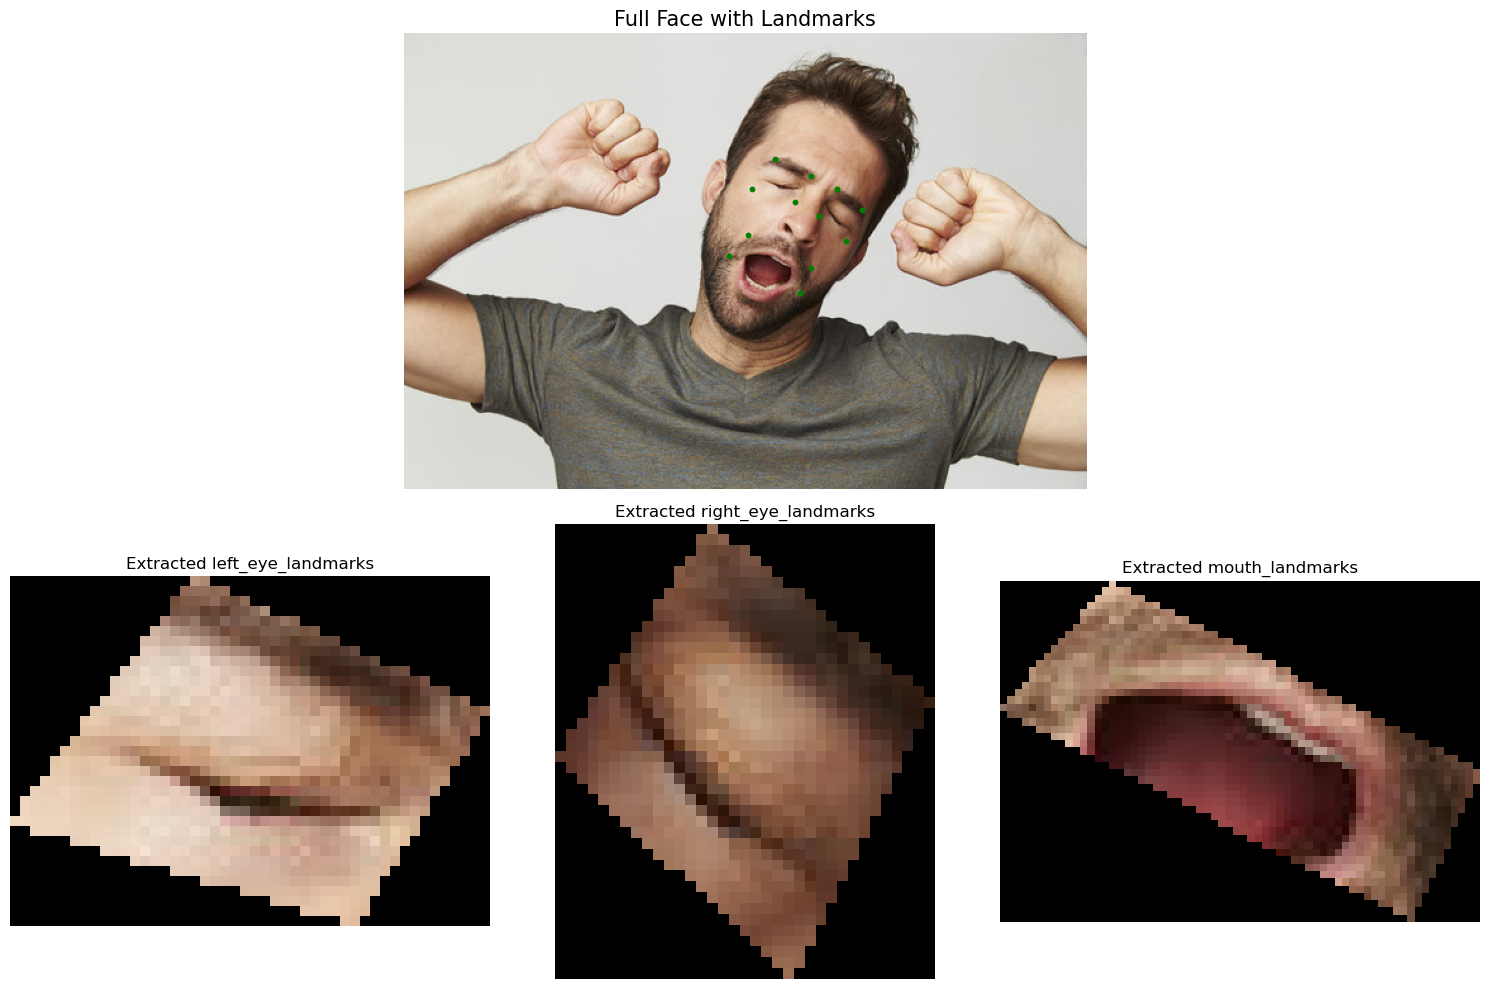

left_eye_landmarks region shape: (35, 48, 3)
right_eye_landmarks region shape: (42, 35, 3)
mouth_landmarks region shape: (47, 66, 3)


In [49]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Initialize the detector
detector = FeatureExtraction(refine_landmarks=False)

# Read an image
image = cv2.imread("/Users/ahmedalkhulayfi/Downloads/360_F_136439169_Ih8iIKpTsG2SFsl02rXfyBKzrplMzh38.jpg")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Get landmarks
landmarks = detector.extract_features(image)

# Create figure with 2 rows: full face on top, extracted regions on bottom
fig = plt.figure(figsize=(15, 10))

# Plot full face with landmarks in first row
ax1 = plt.subplot(2, 1, 1)
ax1.imshow(image_rgb)
ax1.set_title('Full Face with Landmarks', fontsize=15)
ax1.axis('off')

# Plot landmarks on full face
for feature in ['left_eye_landmarks', 'right_eye_landmarks', 'mouth_landmarks']:
    for landmark in landmarks[feature]:
        ax1.scatter(landmark[0], landmark[1], c='g', s=10)

# Create three subplots in second row for extracted regions
ax2 = plt.subplot(2, 3, 4)
ax3 = plt.subplot(2, 3, 5)
ax4 = plt.subplot(2, 3, 6)

# Get and display extracted regions using convex hull
features = ['left_eye_landmarks', 'right_eye_landmarks', 'mouth_landmarks']
axes = [ax2, ax3, ax4]

for feature, ax in zip(features, axes):
    # Get region using convex hull
    region = get_convex_hull_region(image_rgb, landmarks[feature], padding=100)
    
    if region is not None:
        print(region.shape)
        ax.imshow(region)
        ax.set_title(f'Extracted {feature}', fontsize=12)
        ax.axis('off')

plt.tight_layout()
plt.show()

# Print region shapes for verification
for feature in features:
    region = get_convex_hull_region(image_rgb, landmarks[feature], padding=100)
    if region is not None:
        print(f"{feature} region shape: {region.shape}")

# Polygon Masking

In [50]:
def get_polygon_region(img, landmarks):
    if not landmarks:
        return None

    # Convert landmarks to a NumPy array
    points = np.array(landmarks, dtype=np.int32)

    # Create a mask for the region
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    cv2.fillPoly(mask, [points], 255)

    # Extract the region using the mask
    region = cv2.bitwise_and(img, img, mask=mask)

    return region

(360, 540, 3)
(360, 540, 3)
(360, 540, 3)


I0000 00:00:1737193572.999259   33360 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1
W0000 00:00:1737193573.001812  118986 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737193573.007103  118981 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


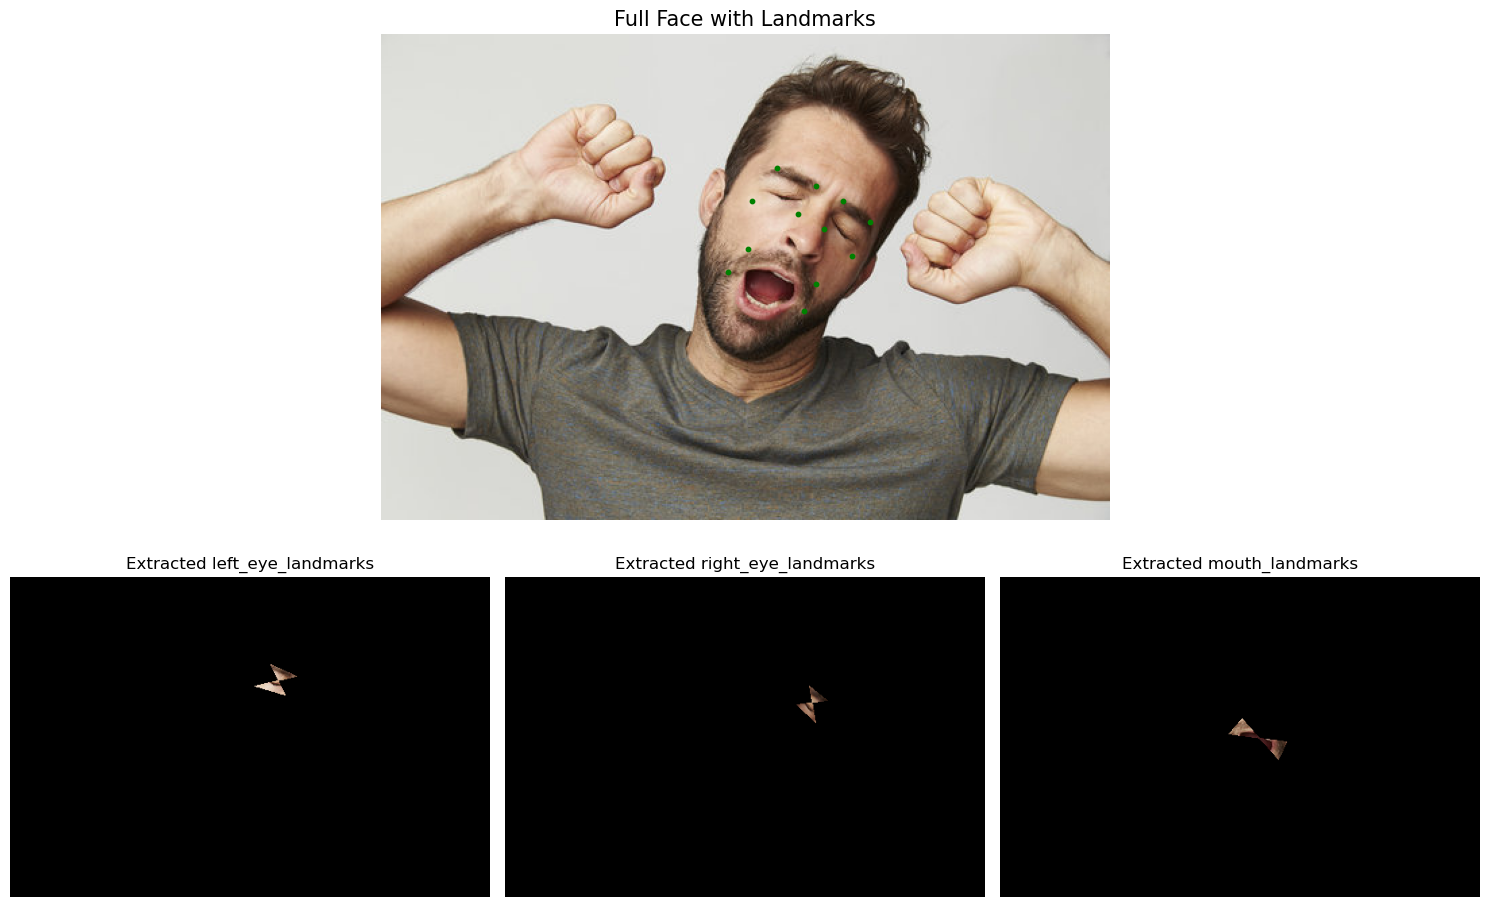

left_eye_landmarks region shape: (360, 540, 3)
right_eye_landmarks region shape: (360, 540, 3)
mouth_landmarks region shape: (360, 540, 3)


In [51]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Initialize the detector
detector = FeatureExtraction(refine_landmarks=False)

# Read an image
image = cv2.imread("/Users/ahmedalkhulayfi/Downloads/360_F_136439169_Ih8iIKpTsG2SFsl02rXfyBKzrplMzh38.jpg")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Get landmarks
landmarks = detector.extract_features(image)

# Create figure with 2 rows: full face on top, extracted regions on bottom
fig = plt.figure(figsize=(15, 10))

# Plot full face with landmarks in first row
ax1 = plt.subplot(2, 1, 1)
ax1.imshow(image_rgb)
ax1.set_title('Full Face with Landmarks', fontsize=15)
ax1.axis('off')

# Plot landmarks on full face
for feature in ['left_eye_landmarks', 'right_eye_landmarks', 'mouth_landmarks']:
    for landmark in landmarks[feature]:
        ax1.scatter(landmark[0], landmark[1], c='g', s=10)

# Create three subplots in second row for extracted regions
ax2 = plt.subplot(2, 3, 4)
ax3 = plt.subplot(2, 3, 5)
ax4 = plt.subplot(2, 3, 6)

# Get and display extracted regions using convex hull
features = ['left_eye_landmarks', 'right_eye_landmarks', 'mouth_landmarks']
axes = [ax2, ax3, ax4]

for feature, ax in zip(features, axes):
    # Get region using convex hull
    region = get_polygon_region(image_rgb, landmarks[feature])
    
    if region is not None:
        print(region.shape)
        ax.imshow(region)
        ax.set_title(f'Extracted {feature}', fontsize=12)
        ax.axis('off')

plt.tight_layout()
plt.show()

# Print region shapes for verification
for feature in features:
    region = get_polygon_region(image_rgb, landmarks[feature])
    if region is not None:
        print(f"{feature} region shape: {region.shape}")

#  Delaunay Triangulation

In [52]:

def get_delaunay_region(img, landmarks):
    if not landmarks:
        return None

    # Convert landmarks to a NumPy array
    points = np.array(landmarks, dtype=np.float32)

    # Create Delaunay triangulation
    rect = (0, 0, img.shape[1], img.shape[0])
    subdiv = cv2.Subdiv2D(rect)
    for p in points:
        subdiv.insert((p[0], p[1]))

    # Get the triangles
    triangle_list = subdiv.getTriangleList()
    triangles = []

    for t in triangle_list:
        pt1 = (int(t[0]), int(t[1]))
        pt2 = (int(t[2]), int(t[3]))
        pt3 = (int(t[4]), int(t[5]))
        triangles.append([pt1, pt2, pt3])

    # Create a mask for the region
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    for triangle in triangles:
        cv2.fillConvexPoly(mask, np.array(triangle, dtype=np.int32), 255)

    # Extract the region using the mask
    region = cv2.bitwise_and(img, img, mask=mask)

    # Get the bounding box of the mask
    x, y, w, h = cv2.boundingRect(np.array(triangles).reshape(-1, 2))
    cropped_region = region[y:y+h, x:x+w]

    # Remove black pixels by creating a new image with only the relevant pixels
    if cropped_region.size == 0:
        return None

    # Create a mask for the cropped region
    cropped_mask = cv2.cvtColor(cropped_region, cv2.COLOR_BGR2GRAY)
    _, binary_mask = cv2.threshold(cropped_mask, 1, 255, cv2.THRESH_BINARY)

    # Use the binary mask to extract the non-black pixels
    final_region = cv2.bitwise_and(cropped_region, cropped_region, mask=binary_mask)

    return final_region

I0000 00:00:1737193573.457235   33360 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1
W0000 00:00:1737193573.459458  118993 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737193573.463717  118994 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


(35, 48, 3)
(42, 35, 3)
(47, 66, 3)


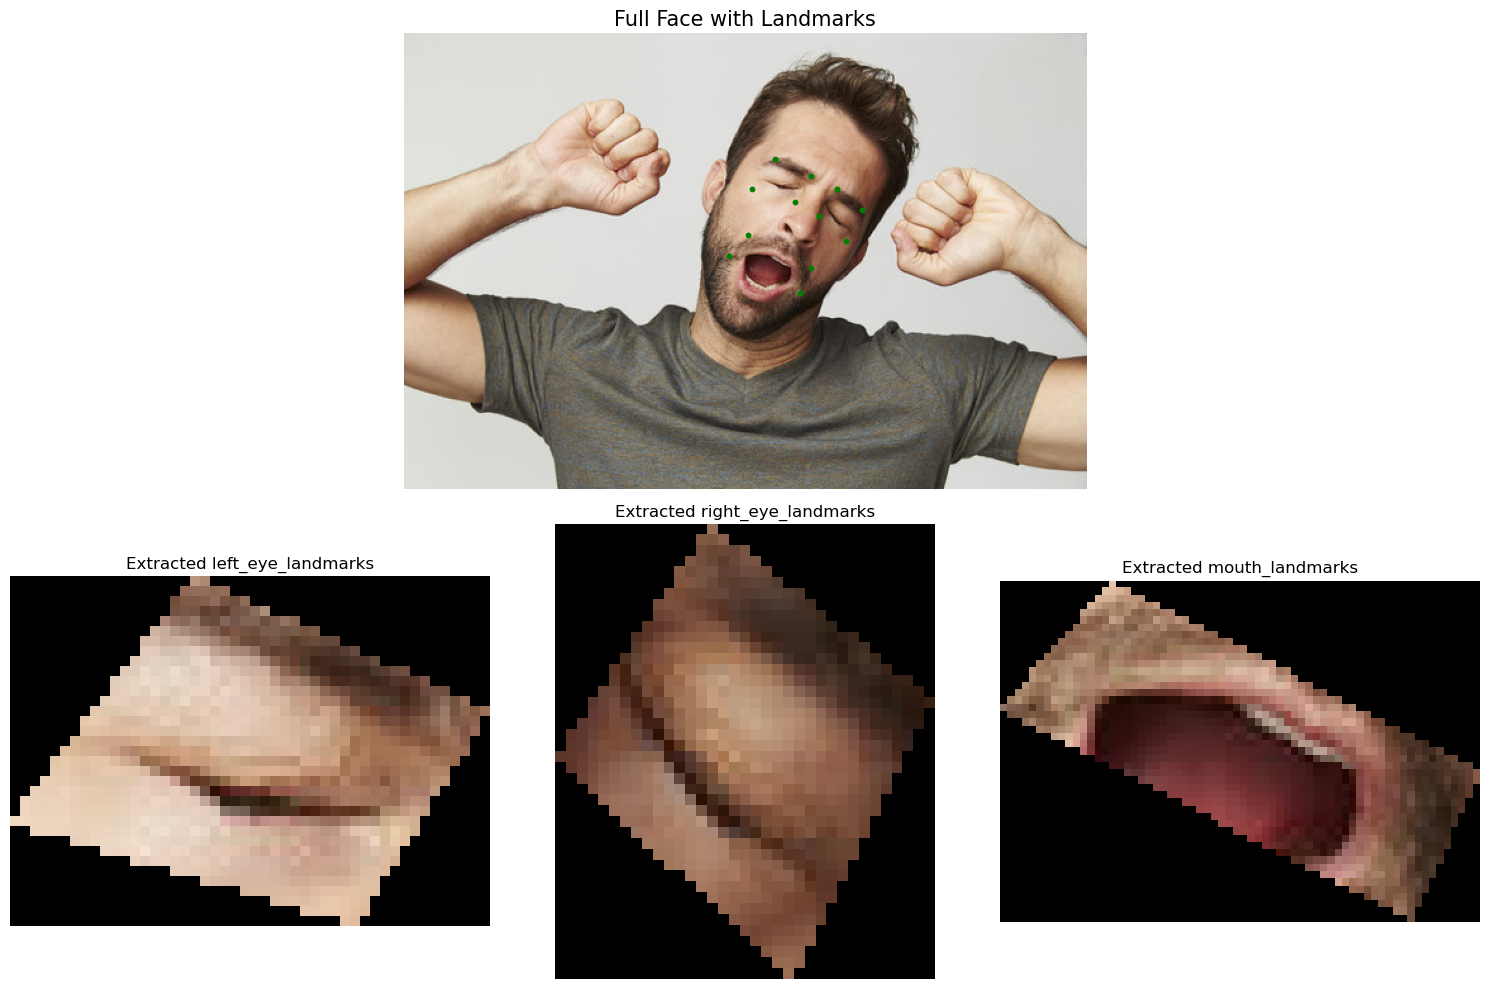

left_eye_landmarks region shape: (35, 48, 3)
right_eye_landmarks region shape: (42, 35, 3)
mouth_landmarks region shape: (47, 66, 3)


In [53]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Initialize the detector
detector = FeatureExtraction(refine_landmarks=False)

# Read an image
image = cv2.imread("/Users/ahmedalkhulayfi/Downloads/360_F_136439169_Ih8iIKpTsG2SFsl02rXfyBKzrplMzh38.jpg")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Get landmarks
landmarks = detector.extract_features(image)

# Create figure with 2 rows: full face on top, extracted regions on bottom
fig = plt.figure(figsize=(15, 10))

# Plot full face with landmarks in first row
ax1 = plt.subplot(2, 1, 1)
ax1.imshow(image_rgb)
ax1.set_title('Full Face with Landmarks', fontsize=15)
ax1.axis('off')

# Plot landmarks on full face
for feature in ['left_eye_landmarks', 'right_eye_landmarks', 'mouth_landmarks']:
    for landmark in landmarks[feature]:
        ax1.scatter(landmark[0], landmark[1], c='g', s=10)

# Create three subplots in second row for extracted regions
ax2 = plt.subplot(2, 3, 4)
ax3 = plt.subplot(2, 3, 5)
ax4 = plt.subplot(2, 3, 6)

# Get and display extracted regions using convex hull
features = ['left_eye_landmarks', 'right_eye_landmarks', 'mouth_landmarks']
axes = [ax2, ax3, ax4]

for feature, ax in zip(features, axes):
    # Get region using convex hull
    region = get_delaunay_region(image_rgb, landmarks[feature])
    
    if region is not None:
        print(region.shape)
        ax.imshow(region)
        ax.set_title(f'Extracted {feature}', fontsize=12)
        ax.axis('off')

plt.tight_layout()
plt.show()

# Print region shapes for verification
for feature in features:
    region = get_delaunay_region(image_rgb, landmarks[feature])
    if region is not None:
        print(f"{feature} region shape: {region.shape}")

[(251, 154), (291, 156), (253, 189), (294, 182)]


I0000 00:00:1737193573.867733   33360 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1
W0000 00:00:1737193573.869788  119009 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737193573.881369  119014 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


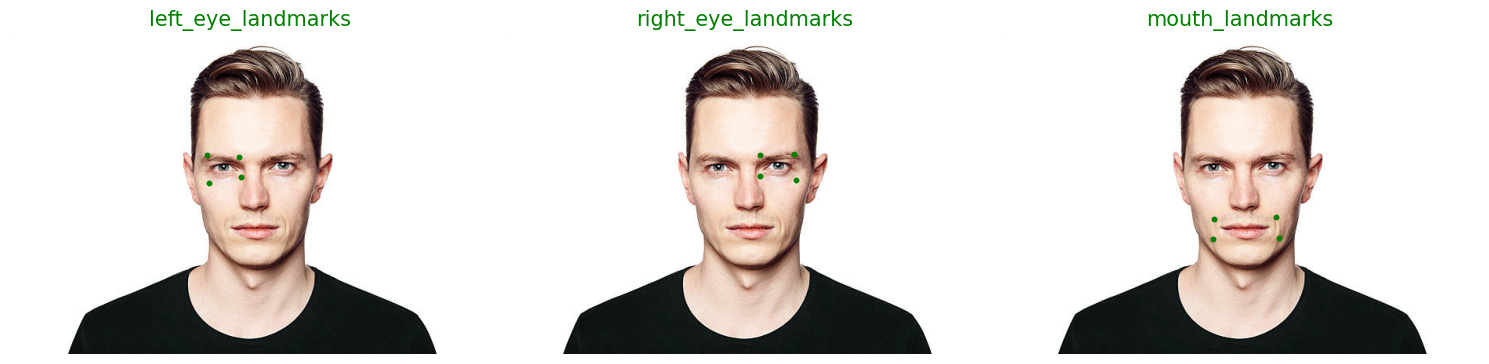

In [54]:
import matplotlib.pyplot as plt

# Initialize the FaceMeshDetector with refined iris landmarks for better precision
detector = FeatureExtraction(refine_landmarks=True)

# Define the facial features (eyes, nose, mouth, iris, and all landmarks) we are interested in
face_parts =  ["left_eye_landmarks", "right_eye_landmarks", "mouth_landmarks", ]


# Read an image from a specified file path
image = cv2.imread("/Users/ahmedalkhulayfi/Downloads/istockphoto-507995592-612x612.jpg")

# Convert the image to RGB for matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Use the FaceMeshDetector to find facial landmarks in the current frame
landmarks = detector.extract_features(image)
print(landmarks["left_eye_landmarks"])

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Iterate over each face part and corresponding subplot
for i, face_part in enumerate(face_parts):
    ax = axes[i]
    ax.imshow(image_rgb)
    ax.axis('off')
    ax.set_title(face_part, fontsize=15, color='green')

    # Try to draw the landmarks for the specified face part
    try:
        for landmark in landmarks[face_part]:
            ax.scatter(landmark[0], landmark[1], c='g', s=10)  # Green color, size 10
    except KeyError:
        # If the landmark for the specified part is not found, skip drawing
        pass

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [55]:
!pip install dlib

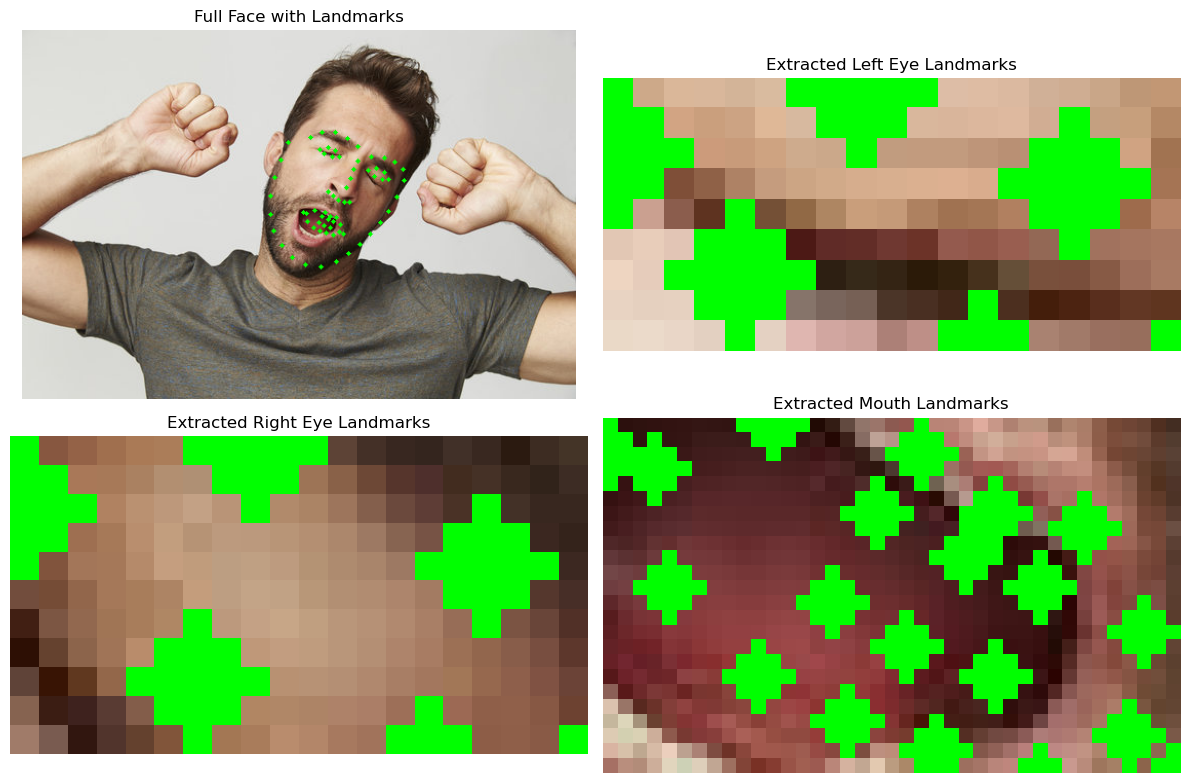

In [56]:
import cv2
import dlib
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread('/Users/ahmedalkhulayfi/Downloads/360_F_136439169_Ih8iIKpTsG2SFsl02rXfyBKzrplMzh38.jpg')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Initialize dlib's face detector and create a landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/Users/ahmedalkhulayfi/Downloads/shape_predictor_68_face_landmarks.dat')

# Detect faces in the image
faces = detector(image_rgb)

# Prepare to store landmarks
left_eye_landmarks = []
right_eye_landmarks = []
mouth_landmarks = []

for face in faces:
    # Get the landmarks
    landmarks = predictor(image_rgb, face)

    # Extract landmarks for left eye, right eye, and mouth
    left_eye_landmarks = [(landmarks.part(i).x, landmarks.part(i).y) for i in range(36, 42)]
    right_eye_landmarks = [(landmarks.part(i).x, landmarks.part(i).y) for i in range(42, 48)]
    mouth_landmarks = [(landmarks.part(i).x, landmarks.part(i).y) for i in range(48, 68)]

    # Draw landmarks on the full face image
    for i in range(68):
        cv2.circle(image_rgb, (landmarks.part(i).x, landmarks.part(i).y), 2, (0, 255, 0), -1)

# Define ROIs for left eye, right eye, and mouth
left_eye_roi = image_rgb[
    min(y for x, y in left_eye_landmarks):max(y for x, y in left_eye_landmarks),
    min(x for x, y in left_eye_landmarks):max(x for x, y in left_eye_landmarks)
]

right_eye_roi = image_rgb[
    min(y for x, y in right_eye_landmarks):max(y for x, y in right_eye_landmarks),
    min(x for x, y in right_eye_landmarks):max(x for x, y in right_eye_landmarks)
]

mouth_roi = image_rgb[
    min(y for x, y in mouth_landmarks):max(y for x, y in mouth_landmarks),
    min(x for x, y in mouth_landmarks):max(x for x, y in mouth_landmarks)
]

# Plot the images
plt.figure(figsize=(12, 8))

# Full face with landmarks
plt.subplot(2, 2, 1)
plt.imshow(image_rgb)
plt.title('Full Face with Landmarks')
plt.axis('off')

# Extracted left eye landmarks
plt.subplot(2, 2, 2)
plt.imshow(left_eye_roi)
plt.title('Extracted Left Eye Landmarks')
plt.axis('off')

# Extracted right eye landmarks
plt.subplot(2, 2, 3)
plt.imshow(right_eye_roi)
plt.title('Extracted Right Eye Landmarks')
plt.axis('off')

# Extracted mouth landmarks
plt.subplot(2, 2, 4)
plt.imshow(mouth_roi)
plt.title('Extracted Mouth Landmarks')
plt.axis('off')

plt.tight_layout()
plt.show()